In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols, sqrt, Eq
import decimal as d
D = d.Decimal
plt.rcParams['figure.figsize'] = [6,6]

# Solidly Analysis (Freeze03)

## Equations

### Invariant function

The Solidly invariant function is 

$$
    x^3y+xy^3 = k
$$

which is a stable swap curve, but more convex than say curve. 

In [2]:
def invariant_eq(x, y, k=0, *, aserr=False):
    """returns f(x,y)-k or f(x,y)/k - 1"""
    if aserr:
        return (x**3 * y + x * y**3)/k-1
    else:
        return x**3 * y + x * y**3 - k

### Swap equation

Solving the invariance equation as $y=y(x; k)$ gives the following result

$$
y(x;k) = \frac{x^2}{\left(-\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}\right)^{\frac{1}{3}}} - \frac{\left(-\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}\right)^{\frac{1}{3}}}{3}
$$

We can introduce intermediary variables $L(x;k), M(x;k)$ to write this a bit more simply

$$
L = -\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}
$$

$$
M = L^{1/3} = \sqrt[3]{L}
$$

$$
y = \frac{x^2}{\sqrt[3]{L}} - \frac{\sqrt[3]{L}}{3} = \frac{x^2}{M} - \frac{M}{3} 
$$

Using the function $y(x;k)$ we can easily derive the swap equation at point $(x; k)$ as

$$
\Delta y = y(x+\Delta x; k) - y(x; k)
$$

In [3]:
x, k = symbols('x k')

y = x**2 / ((-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**(1/3)) - (-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**(1/3)/3
y

x**2/(-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**0.333333333333333 - (-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**0.333333333333333/3

In [4]:
L = -27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2
y2 = x**2 / (L**(1/3)) - (L**(1/3))/3
y2

x**2/(-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**0.333333333333333 - (-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**0.333333333333333/3

#### Precision issues and L

Note that as above, $L$ (that we call $L_1$ now) is not particularly well conditioned. 

$$
L_1 = -\frac{27k}{2x} + \sqrt{\frac{729k^2}{x^2} + 108x^6}
$$

This alternative form works better

$$
L_2(x;k) = \frac{27k}{2x} \left(\sqrt{1 + \frac{108x^8}{729k^2}} - 1 \right)
$$

Furthermore

$$
\sqrt{1+\xi}-1 = \frac{\xi}{2} - \frac{\xi^2}{8} + \frac{\xi^3}{16} - \frac{5\xi^4}{128} + O(\xi^5)
$$

In [5]:
def L1(x,k):
    return -27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2

def L2(x,k):
    xi = (108 * x**8) / (729 * k**2)
    #print(f"xi = {xi}")
    if xi > 1e-5:
        lam = (m.sqrt(1 + xi) - 1)
    else:
        lam = xi*(1/2 - xi*(1/8 - xi*(1/16 - 0.0390625*xi)))
        # the relative error of this Taylor approximation is for xi < 0.025 is 1e-5 or better
        # for xi ~ 1e-15 the full term is unstable (because 1 + 1e-16 ~ 1 in double precision)
        # therefore the switchover should happen somewhere between 1e-12 and 1e-2
    #lam1 = 0
    #lam2 = xi/2 - xi**2/8 
    #lam2 = xi/2 - xi**2/8 + xi**3/16 - 0.0390625*xi**4
    #lam2 = xi*(1/2 - xi*(1/8 - xi*(1/16 - 0.0390625*xi)))
    #lam = max(lam1, lam2)
        # for very small xi we can get zero or close to zero in the full formula
        # in this case the taulor approximation is better because for small xi it is always > 0
        # we simply use the max of the two -- the Taylor gets negative quickly
    L = lam * (27 * k) / (2 * x)
    return L

def L3(x,k):
    """going via decimal"""
    x = D(x)
    k = D(k)
    xi = (108 * x**8) / (729 * k**2)
    lam = (D(1) + xi).sqrt() - D(1)
    L = lam * (27 * k) / (2 * x)
    return float(L)

In [6]:
L1(0.1, 1), L2(0.1,1)

(9.99999940631824e-8, 9.9999999962963e-08)

In [7]:
M = L**(1/3)
y3 = x**2 / M - M/3
y3

x**2/(-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**0.333333333333333 - (-27*k/(2*x) + sqrt(729*k**2/x**2 + 108*x**6)/2)**0.333333333333333/3

In [8]:
assert y  == y2
assert y  == y3
assert y2 == y3

In [9]:
def swap_eq(x,k):
    """using floats only"""
    L,M,y = [None]*3
    try:
        #L = -27*k/(2*x) + m.sqrt(729*k**2/x**2 + 108*x**6)/2
        L = L2(x,k)
        M = L**(1/3)
        y = x**2/M - M/3
    except Exception as e:
        print("Exception: ", e)
        print(f"x={x}, k={k}, L={L}, M={M}, y={y}")
    return y

def swap_eq_dec(x,k):
    """using decimals for the calculation of L"""
    L,M,y = [None]*3
    try:
        #L = -27*k/(2*x) + m.sqrt(729*k**2/x**2 + 108*x**6)/2
        L = L3(x,k)
        M = L**(1/3)
        y = x**2/M - M/3
    except Exception as e:
        print("Exception: ", e)
        print(f"x={x}, k={k}, L={L}, M={M}, y={y}")
    return y

In [10]:
def swap_eq2(x, k):
    # Calculating the components of the swap equation
    term1_numerator = (2/3)**(1/3) * x**3
    term1_denominator = (9 * k * x**2 + m.sqrt(3) * m.sqrt(27 * k**2 * x**4 + 4 * x**12))**(1/3)

    term2_numerator = (9 * k * x**2 + m.sqrt(3) * m.sqrt(27 * k**2 * x**4 + 4 * x**12))**(1/3)
    term2_denominator = 2**(1/3) * 3**(2/3) * x

    # Swap equation calculation
    y = -term1_numerator / term1_denominator + term2_numerator / term2_denominator

    return y

# Example usage
x_value = 1  # Replace with the desired value of x
k_value = 1  # Replace with the desired value of k
print(swap_eq(x_value, k_value))

0.6823278038280196


### Price equation

The derivative $p=dy/dx$ is as follows

$$
p=\frac{dy}{dx} = 6^{\frac{1}{3}}\left(\frac{-2 \cdot 3^{\frac{1}{3}} \cdot x \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}} \cdot \left(-9k + \sqrt{3} \cdot x \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}}\right) \cdot \left(3k \cdot x \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}} + \sqrt{3} \cdot \left(-9k^2 + 4x^8\right)\right) + 2^{\frac{1}{3}} \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}} \cdot \left(\frac{-9k + \sqrt{3} \cdot x \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}}}{x}\right)^{\frac{5}{3}} \cdot \left(-3k \cdot x \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}} + \sqrt{3} \cdot \left(9k^2 - 4x^8\right)\right) + 4 \cdot 3^{\frac{1}{3}} \cdot \left(-9k + \sqrt{3} \cdot x \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}}\right)^2 \cdot \left(27k^2 + 4x^8\right)}{6 \cdot x \cdot \left(\frac{-9k + \sqrt{3} \cdot x \cdot \sqrt{\frac{27k^2 + 4x^8}{x^2}}}{x}\right)^{\frac{7}{3}} \cdot \left(27k^2 + 4x^8\right)}\right)
$$



In [11]:
def price_eq(x, k):
    # Components of the derivative
    term1_numerator = 2**(1/3) * x**3 * (18 * k * x + (m.sqrt(3) * (108 * k**2 * x**3 + 48 * x**11)) / (2 * m.sqrt(27 * k**2 * x**4 + 4 * x**12)))
    term1_denominator = 3 * (9 * k * x**2 + m.sqrt(3) * m.sqrt(27 * k**2 * x**4 + 4 * x**12))**(4/3)
    
    term2_numerator = 18 * k * x + (m.sqrt(3) * (108 * k**2 * x**3 + 48 * x**11)) / (2 * m.sqrt(27 * k**2 * x**4 + 4 * x**12))
    term2_denominator = 3 * 2**(1/3) * 3**(2/3) * x * (9 * k * x**2 + m.sqrt(3) * m.sqrt(27 * k**2 * x**4 + 4 * x**12))**(2/3)
    
    term3 = -3 * 2**(1/3) * x**2 / (9 * k * x**2 + m.sqrt(3) * m.sqrt(27 * k**2 * x**4 + 4 * x**12))**(1/3)
    
    term4 = -(9 * k * x**2 + m.sqrt(3) * m.sqrt(27 * k**2 * x**4 + 4 * x**12))**(1/3) / (2**(1/3) * 3**(2/3) * x**2)
    
    # Combining all terms
    dy_dx = (term1_numerator / term1_denominator) + (term2_numerator / term2_denominator) + term3 + term4

    return dy_dx

# Example usage
x_value = 1  # Replace with the desired value of x
k_value = 1  # Replace with the desired value of k
print(price_eq(x_value, k_value))


-1.3136251299197979


#### Inverting the price equation

The above equations 
([obtained thanks to Wolfram Alpha](https://chat.openai.com/share/55151f92-411c-43c1-a6ec-180856762a82), 
the interface of which still sucks) are rather complex, and unfortunately they can't apparently be inverted analytically to get $x=x(p;k)$

## Charts

### Invariant equation

In [12]:
y_f = swap_eq

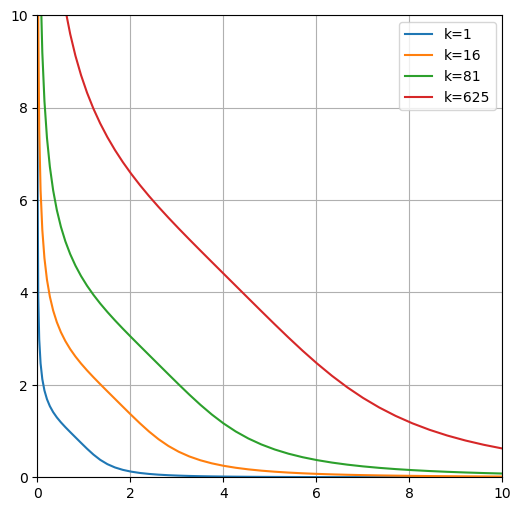

In [13]:
k_v = [1**4, 2**4, 3**4, 5**4]
#k_v = [1**4]
x_v = np.linspace(0, m.sqrt(10), 50)
x_v = [xx**2 for xx in x_v]
x_v[0] = x_v[1]/2
y_v_dct = {kk: [y_f(xx, kk) for xx in x_v] for kk in k_v}
plt.grid(True)
for kk, y_v in y_v_dct.items(): 
    plt.plot(x_v, y_v, marker=None, linestyle='-', label=f"k={kk}")
plt.legend()
plt.xlim(0, max(x_v))
plt.ylim(0, max(x_v))
plt.show()

Checking the invariant equation at a specific point (xx; kk)

In [14]:
kk = 625
xx = 3
invariant_eq(x=xx, y=swap_eq(xx, kk), k=kk, aserr=True)

5.773159728050814e-15

Calculating a histogram of relative errors, ie what the relative error in the invariant equation is at various points $xx$ of the swap equation and at various $kk$

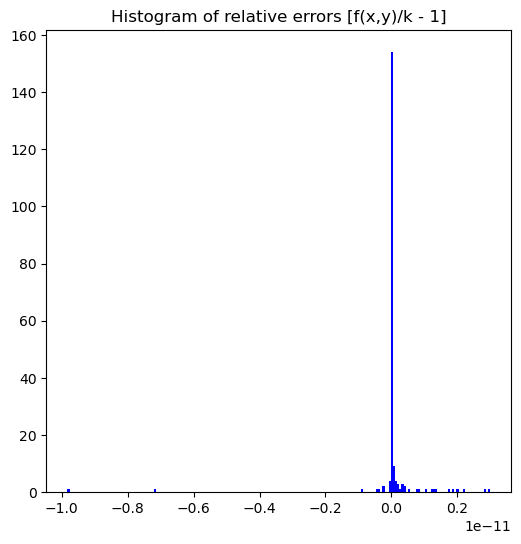

In [15]:
y_inv_dct = {kk: [invariant_eq(x=xx, y=swap_eq(xx, kk), k=kk, aserr=True) for xx in x_v] for kk in k_v}
y_inv_lst = [v for lst in y_inv_dct.values() for v in lst]
#y_inv_lst
plt.hist(y_inv_lst, bins=200, color="blue")
plt.title("Histogram of relative errors [f(x,y)/k - 1]")
plt.show()

Maximum relative error for different values of $k$

In [16]:
{k: max([abs(vv) for vv in v]) for k,v in y_inv_dct.items()}

{1: 2.9978242110928477e-12,
 16: 2.220890138460163e-12,
 81: 9.826917057864648e-12,
 625: 7.190470441287289e-12}

Minimum relative error for different values of $k$

In [17]:
{k: min([abs(vv) for vv in v]) for k,v in y_inv_dct.items()}

{1: 0.0, 16: 2.220446049250313e-16, 81: 4.440892098500626e-16, 625: 0.0}

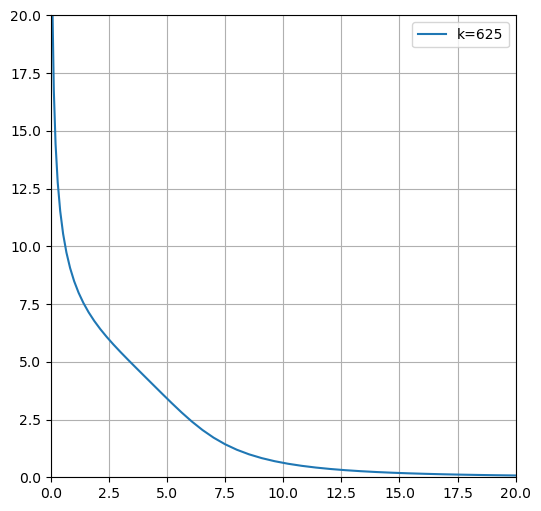

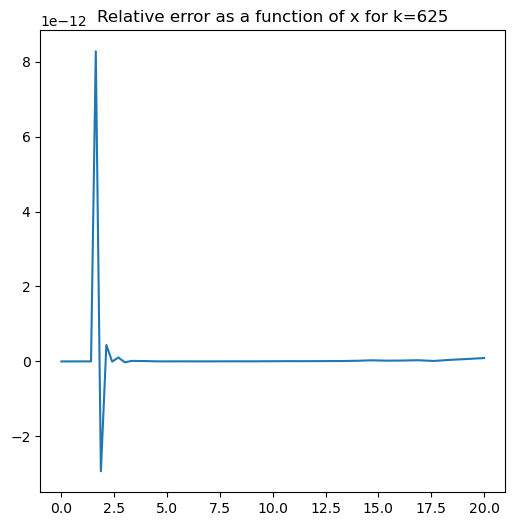

In [18]:
kk = 5**4
x_v = np.linspace(0, m.sqrt(20), 50)
x_v = [xx**2 for xx in x_v]
x_v[0] = x_v[1]/2
plt.grid(True)
plt.plot(x_v, [y_f(xx, kk) for xx in x_v], marker=None, linestyle='-', label=f"k={kk}")
inv_dct = {xx: invariant_eq(x=xx, y=swap_eq(xx, kk), k=kk, aserr=True) for xx in x_v}
plt.legend()
plt.xlim(0, max(x_v))
plt.ylim(0, max(x_v))
plt.show()
plt.plot(inv_dct.keys(), inv_dct.values())
plt.title(f"Relative error as a function of x for k={kk}")
plt.show()

Same analysis as above, but much higher resolution

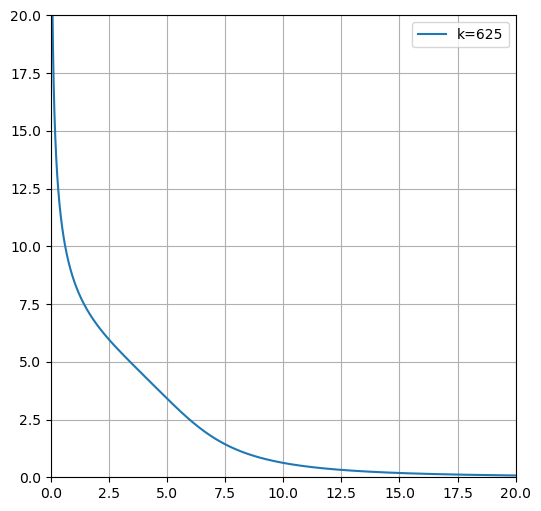

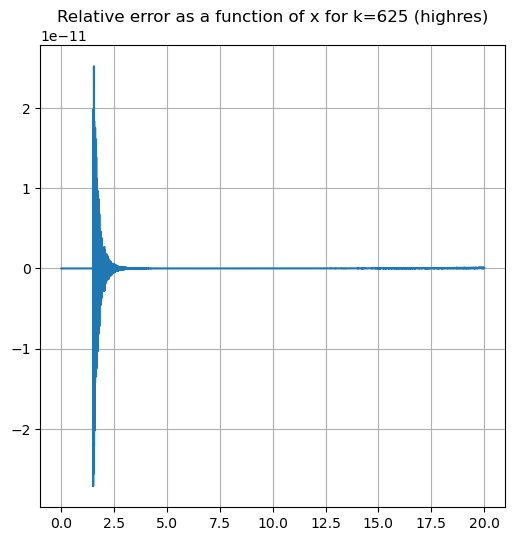

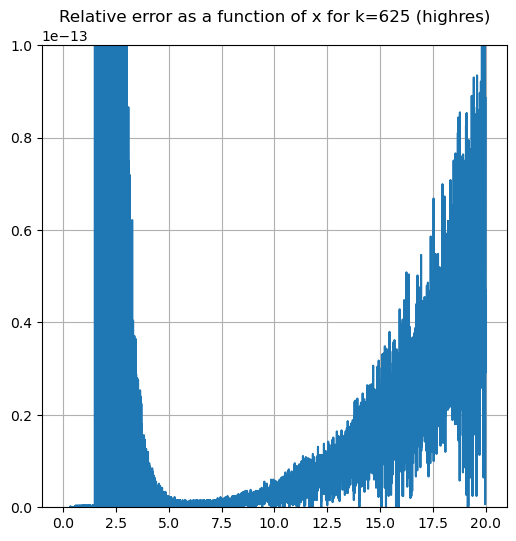

In [19]:
NUMPOINTS = 10000
kk = 5**4
x_v = np.linspace(0, m.sqrt(20), NUMPOINTS)
x_v = [xx**2 for xx in x_v]
x_v[0] = x_v[1]/2
plt.grid(True)
plt.plot(x_v, [y_f(xx, kk) for xx in x_v], marker=None, linestyle='-', label=f"k={kk}")
inv_dct = {xx: invariant_eq(x=xx, y=swap_eq(xx, kk), k=kk, aserr=True) 
#           for xx in x_v[int(0.2*NUMPOINTS):int(0.5*NUMPOINTS)] # <=== CHANGE RANGE HERE
           for xx in x_v # <=== CHANGE RANGE HERE
}
plt.legend()
plt.xlim(0, max(x_v))
plt.ylim(0, max(x_v))
plt.show()
plt.plot(inv_dct.keys(), inv_dct.values())
plt.title(f"Relative error as a function of x for k={kk} (highres)")
plt.grid()
plt.show()
plt.plot(inv_dct.keys(), inv_dct.values())
plt.title(f"Relative error as a function of x for k={kk} (highres)")
plt.grid()
plt.ylim(0,1e-13)
plt.show()

same as above, but using decimal

/var/folders/xd/7hy1yb2x4392l3378tjw70g80000gn/T/ipykernel_70005/2221901752.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  y = x**2/M - M/3


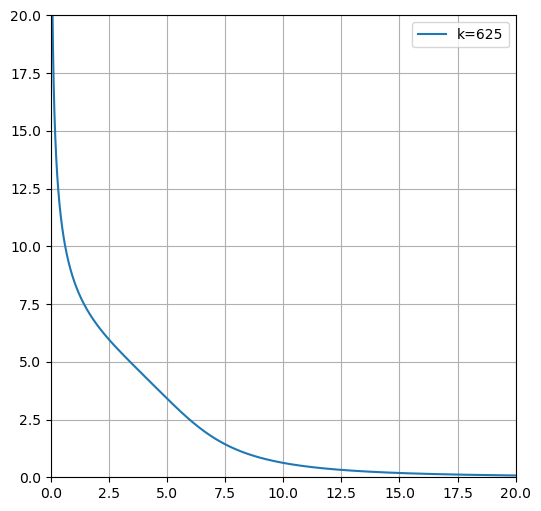

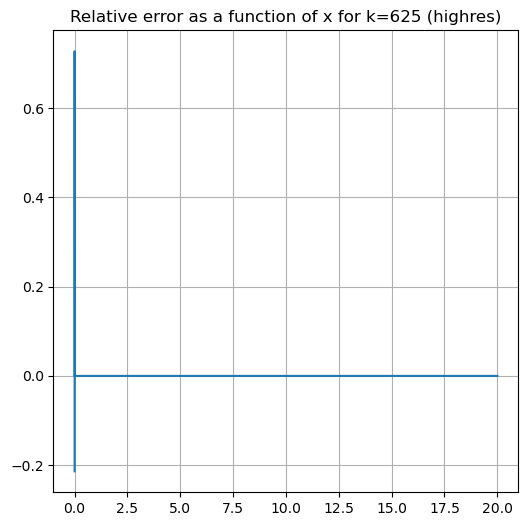

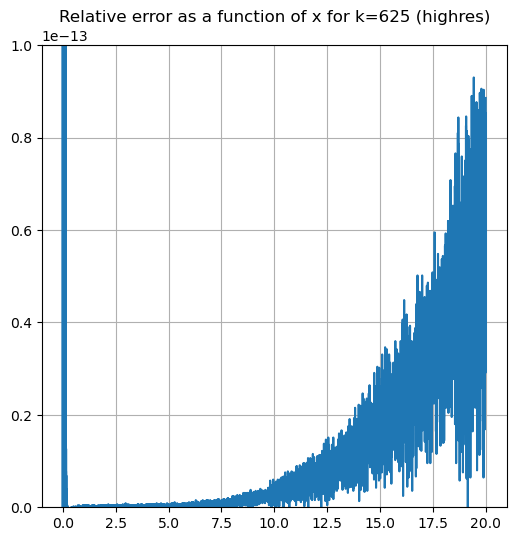

In [20]:
NUMPOINTS = 10000
kk = 5**4
x_v = np.linspace(0, m.sqrt(20), NUMPOINTS)
x_v = [xx**2 for xx in x_v]
x_v[0] = x_v[1]/2
plt.grid(True)
plt.plot(x_v, [y_f(xx, kk) for xx in x_v], marker=None, linestyle='-', label=f"k={kk}")
inv_dct = {xx: invariant_eq(x=xx, y=swap_eq_dec(xx, kk), k=kk, aserr=True) 
#           for xx in x_v[int(0.15*NUMPOINTS):int(0.3*NUMPOINTS)] # <=== CHANGE RANGE HERE
           for xx in x_v 
}
plt.legend()
plt.xlim(0, max(x_v))
plt.ylim(0, max(x_v))
plt.show()
plt.plot(inv_dct.keys(), inv_dct.values())
plt.title(f"Relative error as a function of x for k={kk} (highres)")
plt.grid()
plt.show()
plt.plot(inv_dct.keys(), inv_dct.values())
plt.title(f"Relative error as a function of x for k={kk} (highres)")
plt.grid()
plt.ylim(0,1e-13)
plt.show()

### Numerical considerations
#### Comparing L1 with L2

L1 and L2 are different expressions of the L term above. L2 is the naive formula, L1 is optimized. L2 can be zero for very small values (and it is not even continous; see 0.009 and 0.01 below) whilst L1 is *always* greater than zero.

In [21]:
xs_v = [0.0001, 0.001, 0.009, 0.01, 0.015, 0.02, 0.05]
[(L1(xx,1), L2(xx, 1)) for xx in xs_v]

[(0, 1.0000000000000003e-28),
 (0, 1.0000000000000001e-21),
 (2.27373675443232e-13, 4.7829689999999975e-15),
 (0, 1.0000000000000002e-14),
 (2.27373675443232e-13, 1.7085937499999996e-13),
 (1.25055521493778e-12, 1.279999999999999e-12),
 (7.81199105404085e-10, 7.812499999988701e-10)]

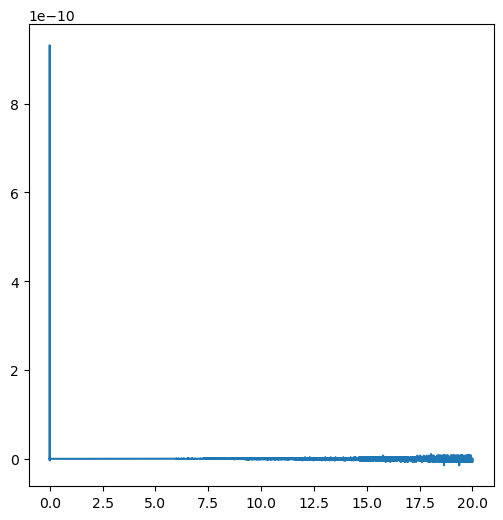

In [22]:
plt.plot(x_v, [L2(xx, 1) - L1(xx, 1) for xx in x_v])

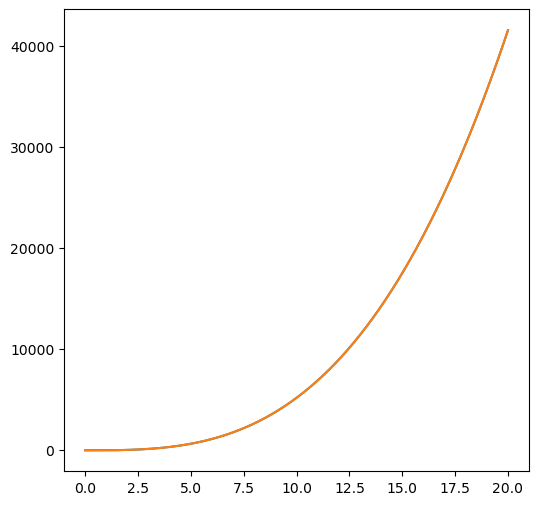

In [23]:
plt.plot(x_v, [L1(xx, 1) for xx in x_v])
plt.plot(x_v, [L2(xx, 1) for xx in x_v])
plt.show()

## Generic numerical questions

### Square root term

Here we are looking at the term $\sqrt{1+\xi}-1$ to understand up to which point we need the Tayler approximation, and whether there is a point going for T4 instead of T4. As a reminder

$$
\sqrt{1+\xi}-1 = \frac{\xi}{2} - \frac{\xi^2}{8} + \frac{\xi^3}{16} - \frac{5\xi^4}{128} + O(\xi^5)
$$

,Float,Taylor2,Taylor4
x,,,
0.005051,0.002522,0.002522,0.002522
0.010101,0.005038,0.005038,0.005038
0.020202,0.010051,0.010050,0.010051
0.030303,0.015038,0.015037,0.015038
0.040404,0.020002,0.019998,0.020002


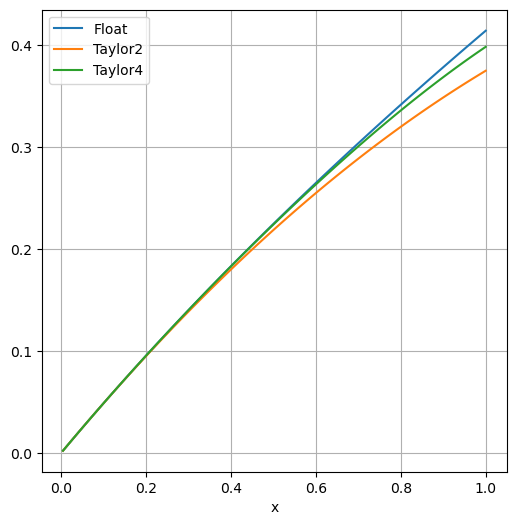

In [24]:
x1_v = np.linspace(0,1,100)
x1_v[0] = x1_v[1]/2
data = [(
    xx, 
    m.sqrt(1+xx)-1,
    xx * (0.5 - xx*1/8),
    #xx/2 - xx**2/8 + xx**3/16 - xx**4 * 5 / 128,
    xx * (0.5 - xx*(1/8 - xx*(1/16 - 5/128*xx))),
) for xx in x1_v
]
df = pd.DataFrame(data, columns=['x', 'Float', 'Taylor2', 'Taylor4']).set_index("x")
df.plot()
plt.grid()
df.head()

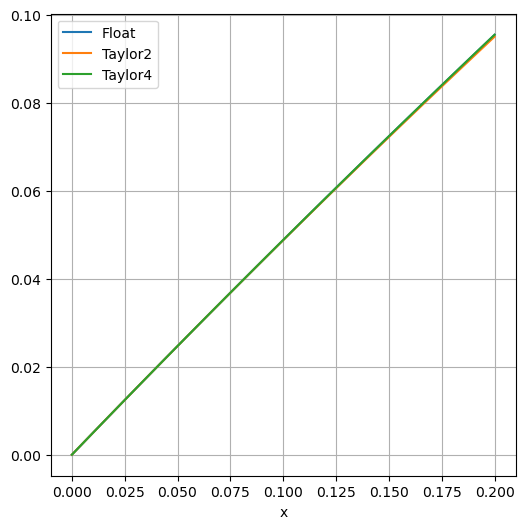

,Float,Taylor2,Taylor4,Err2,Err4
x,,,,,
0.000000,0.000000,0.000000,0.000000,NaN,NaN
0.002020,0.001010,0.001010,0.001010,-5.097660e-07,-8.911760e-13
0.004040,0.002018,0.002018,0.002018,-2.037524e-06,-1.459954e-11
0.006061,0.003026,0.003026,0.003026,-4.580970e-06,-7.353718e-11
0.008081,0.004032,0.004032,0.004032,-8.137814e-06,-2.322379e-10


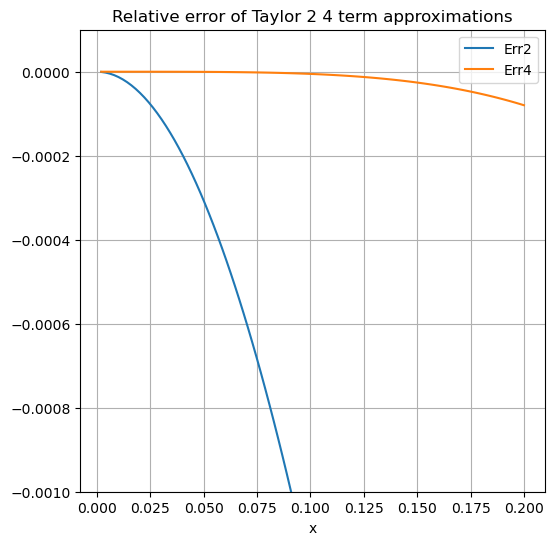

In [25]:
x2_v = np.linspace(0,0.2,100)
x1_v[0] = x1_v[1]/2
data = [(
    xx, 
    m.sqrt(1+xx)-1,
    xx * (0.5 - xx*1/8),
    #xx/2 - xx**2/8 + xx**3/16 - xx**4 * 5 / 128,
    xx * (0.5 - xx*(1/8 - xx*(1/16 - 5/128*xx))),
) for xx in x2_v
]
df = pd.DataFrame(data, columns=['x', 'Float', 'Taylor2', 'Taylor4']).set_index("x")
df.plot()
plt.grid()
df2 = df.copy()
df2["Err2"] = df2["Taylor2"]/df2["Float"] - 1
df2["Err4"] = df2["Taylor4"]/df2["Float"] - 1
plt.show()
df2.plot(y=["Err2", "Err4"])
plt.grid()
plt.title("Relative error of Taylor 2 4 term approximations")
plt.ylim(-0.001, 0.0001)
df2.head()

### Decimal vs float
#### Precision

we compare $\sqrt{1+\xi}-1$ for float, Taylor and Decimal

$$
\sqrt{1+\xi}-1 = \frac{\xi}{2} - \frac{\xi^2}{8} + \frac{\xi^3}{16} - \frac{5\xi^4}{128} + O(\xi^5)
$$

In [26]:
import decimal as d
D = d.Decimal
d.getcontext().prec = 1000  # Set the precision to 30 decimal places (adjust as needed)
xd_v = [1e-18*1.5**nn for nn in np.linspace(0, 103, 500)]
xd_v[0], xd_v[-1]

(1e-18, 1.3721439741813515)

In [27]:
fmt = lambda x: x
fmt = float
ONE = D(1)
data = [(
    xx, 
    m.sqrt(1+xx)-1,
    xx * (0.5 - xx*1/8),
    #xx/2 - xx**2/8 + xx**3/16 - xx**4 * 5 / 128,
    xx * (0.5 - xx*(1/8 - xx*(1/16 - 5/128*xx))),
    fmt((ONE+D(xx)).sqrt()-1),
) for xx in xd_v
]
df = pd.DataFrame(data, columns=['x', 'Float', 'Taylor2', 'Taylor4', 'Dec']).set_index("x")
df.head()

,Float,Taylor2,Taylor4,Dec
x,,,,
1.000000e-18,0.0,5.000000e-19,5.000000e-19,5.000000e-19
1.087295e-18,0.0,5.436476e-19,5.436476e-19,5.436476e-19
1.182211e-18,0.0,5.911055e-19,5.911055e-19,5.911055e-19
1.285412e-18,0.0,6.427062e-19,6.427062e-19,6.427062e-19
1.397623e-18,0.0,6.988114e-19,6.988114e-19,6.988114e-19


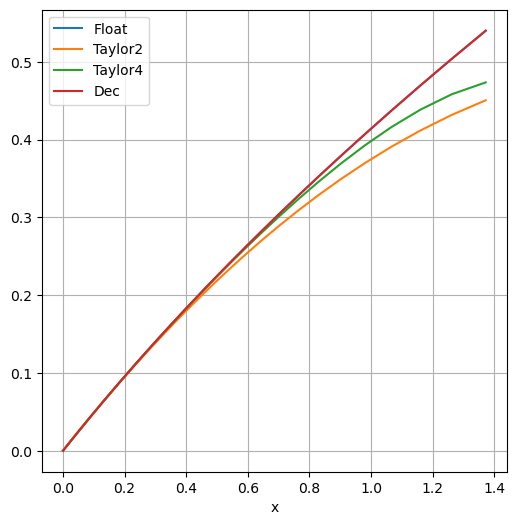

In [28]:
df.plot()
# plt.xlim(0, None)
# plt.ylim(0, 100)
plt.grid()

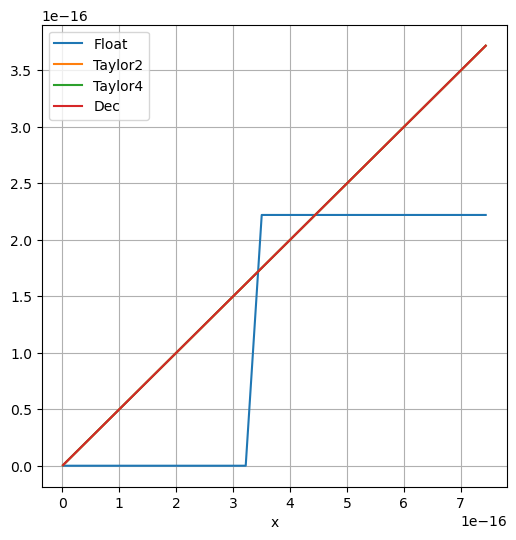

In [29]:
df.iloc[:80].plot()
plt.grid()

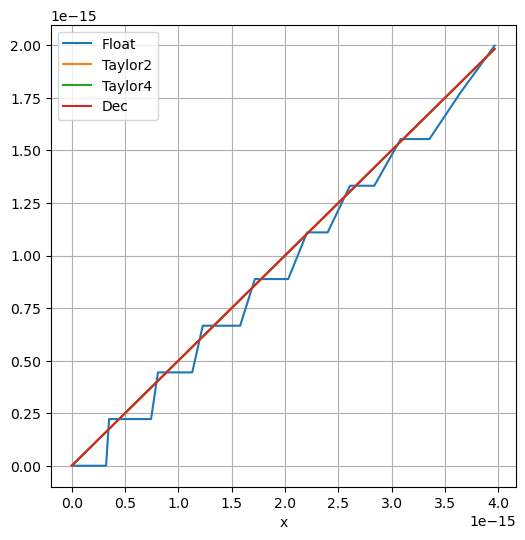

In [30]:
df.iloc[:100].plot()
plt.grid()

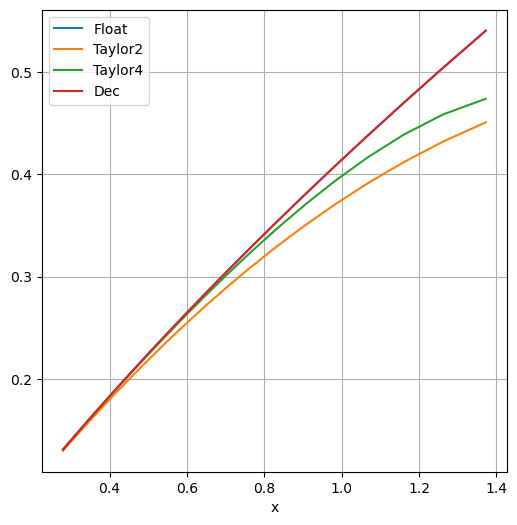

In [31]:
LOC = 480
df.iloc[LOC:].plot()
plt.grid()

In [32]:
df2 = pd.DataFrame([
    (df["Float"]-df["Taylor4"])/df["Taylor4"],
    (df["Taylor2"]-df["Taylor4"])/df["Taylor4"],
    (df["Dec"]-df["Taylor4"])/df["Taylor4"],
]).transpose()
df2.columns = ["Float", "Taylor2", "Dec"]
df2

,Float,Taylor2,Dec
x,,,
1.000000e-18,-1.000000,0.000000,0.000000
1.087295e-18,-1.000000,0.000000,0.000000
1.182211e-18,-1.000000,0.000000,0.000000
1.285412e-18,-1.000000,0.000000,0.000000
1.397623e-18,-1.000000,0.000000,0.000000
...,...,...,...
9.817699e-01,0.036871,-0.058112,0.036871
1.067474e+00,0.051053,-0.060737,0.051053
1.160659e+00,0.070985,-0.061156,0.070985


#### Timing

In [33]:
import time
import decimal as d
D = d.Decimal

In [34]:
def time_func(func, *args, N=None, **kwargs):
    """times the calls to func; func is called with args and kwargs; returns time in msec per 1m calls"""
    if N is None:
        N = 10_000_000
    start_time = time.time()
    for _ in range(N):
        func(*args, **kwargs)
    end_time = time.time()
    return (end_time - start_time)/N*1_000_000*1000

In [35]:
def time_func1(func, arg, N=None):
    """times the calls to func; func is called with arg; returns time in msec per 1m calls"""
    if N is None:
        N = 10_000_000
    start_time = time.time()
    for _ in range(N):
        func(arg)
    end_time = time.time()
    return (end_time - start_time)/N*1_000_000*1000

identify function (`lambda`)

In [36]:
time_func(lambda x: x, 1), time_func1(lambda x: x, 1)

(41.66769981384277, 27.7008056640625)

ditto, defined with `def`

In [37]:
def idfunc(x):
    return x
time_func(idfunc, 1), time_func1(idfunc, 1)

(39.624619483947754, 27.41990089416504)

sin, sqrt, exp etc as reference

In [38]:
(time_func(m.sin, 1), time_func(m.cos, 1), time_func(m.tan, 1), 
 time_func(m.sqrt, 1), time_func(m.exp, 1), time_func(m.log, 1))

(51.15928649902344,
 50.94408988952637,
 59.79418754577637,
 39.32750225067139,
 44.03328895568848,
 45.121097564697266)

In [39]:
(time_func1(m.sin, 1), time_func1(m.cos, 1), time_func1(m.tan, 1), 
 time_func1(m.sqrt, 1), time_func1(m.exp, 1), time_func1(m.log, 1))

(38.51971626281738,
 38.30740451812744,
 39.91541862487793,
 26.962804794311523,
 30.146718025207516,
 42.35830307006836)

**float** calculation

In [40]:
time_func(lambda xx: m.sqrt(1+xx)-1, 1), time_func1(lambda xx: m.sqrt(1+xx)-1, 1)

(82.55062103271484, 65.61510562896729)

**taylor** calculations

In [41]:
time_func(lambda xx: xx * (0.5 - xx*1/8), 1), time_func1(lambda xx: xx * (0.5 - xx*1/8), 1)

(72.03409671783446, 60.68711280822753)

In [42]:
(time_func(lambda xx: xx * (0.5 - xx*(1/8 - xx*(1/16 - 5/128*xx))), 1),
time_func1(lambda xx: xx * (0.5 - xx*(1/8 - xx*(1/16 - 5/128*xx))), 1))

(110.19370555877684, 96.72987461090088)

In [43]:
(time_func(lambda xx: xx/2 - xx**2/8 + xx**3/16 - xx**4 * 5 / 128, 1),
time_func1(lambda xx: xx/2 - xx**2/8 + xx**3/16 - xx**4 * 5 / 128, 1))

(148.4793186187744, 120.42548656463623)

**decimal** calculations

In [44]:
d.getcontext().prec = 30
ONE = D(1)
(time_func(lambda xx: D(1+xx).sqrt()-1,  1, N=100_000),
 time_func(lambda xx: ONE+xx.sqrt()-1, ONE, N=100_000))

(2821.168899536133, 3099.2603302001953)

In [45]:
d.getcontext().prec = 100
ONE = D(1)
(time_func(lambda xx: D(1+xx).sqrt()-1,  1, N=10_000),
 time_func(lambda xx: ONE+xx.sqrt()-1, ONE, N=10_000))

(11717.677116394043, 12349.104881286621)

In [46]:
d.getcontext().prec = 1_000
ONE = D(1)
(time_func(lambda xx: D(1+xx).sqrt()-1,  1, N=1_000),
 time_func(lambda xx: ONE+xx.sqrt()-1, ONE, N=1_000))

(608450.8895874023, 646713.7336730957)

decimal conversions

In [47]:
d.getcontext().prec = 30
ONE = D("0."+"9"*d.getcontext().prec)
PI = m.pi
(time_func(lambda xx: D(xx),  PI, N=1_000_000),
 time_func(lambda: float(ONE), N=1_000_000),
 ONE
)

(399.7950553894043,
 280.5027961730957,
 Decimal('0.999999999999999999999999999999'))

In [48]:
d.getcontext().prec = 100
ONE = D("0."+"9"*d.getcontext().prec)
(time_func(lambda xx: D(xx),  PI, N=1_000_000),
 time_func(lambda: float(ONE), N=1_000_000),
 ONE
)

(396.4359760284424,
 523.1471061706543,
 Decimal('0.9999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999'))

In [49]:
d.getcontext().prec = 1000
ONE = D("0."+"9"*d.getcontext().prec)
(time_func(lambda xx: D(xx),  PI, N=1_000_000),
 time_func(lambda: float(ONE), N=1_000_000),
 ONE
)

(398.88906478881836,
 1889.2371654510498,
 Decimal('0.9999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999